# Discovery test example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import pltdist, plotfitresult

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import FrequentistCalculator
from hepstats.hypotests import Discovery
from hepstats.hypotests.parameters import POI

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 25)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

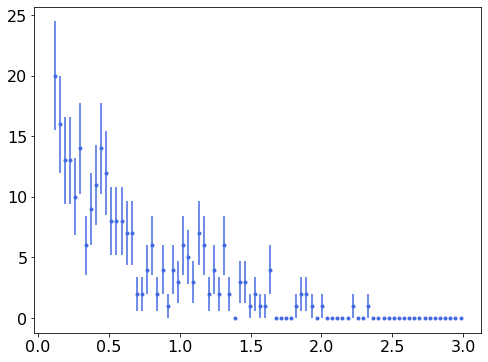

In [4]:
pltdist(data, bins=80, bounds=bounds)

In [5]:
obs = zfit.Space('x', limits=bounds)

In [6]:
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [7]:
signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
tot_model = zfit.pdf.SumPDF([signal, background])

In [8]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [9]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [10]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)
minimum.hesse()
print(minimum)

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


------------------------------------------------------------------
| FCN = -1145                   |      Ncalls=57 (57 total)      |
| EDM = 0.000196 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_3, Composed_autoparam_4] dtype=float64>0] data=[<zfit.core.data.Data object at 0x7fca3fbc9dd0>] constraints=[]> 
w

Text(0, 0.5, 'number of events')

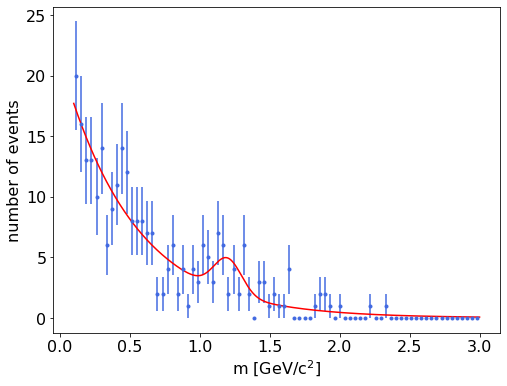

In [11]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Discovery test

In a discovery test the null hypothesis is the absence of signal, .i.e Nsig = 0.

In [12]:
# instantation of the calculator
#calculator = FrequentistCalculator(nll, minimizer, ntoysnull=5000)
calculator = FrequentistCalculator.from_yaml("toys/discovery_freq_zfit_toys.yml", nll, minimizer, ntoysnull=5000)
calculator.bestfit = minimum #optionnal

In [13]:
# parameter of interest of the null hypothesis
poinull = POI(Nsig, 0)

In [14]:
# instantation of the discovery test
discovery_test = Discovery(calculator, poinull)

In [15]:
pnull, significance = discovery_test.result()


p_value for the Null hypothesis = 0.0004
Significance (in units of sigma) = 3.3527947805048592


Text(0.5, 0, 'q')

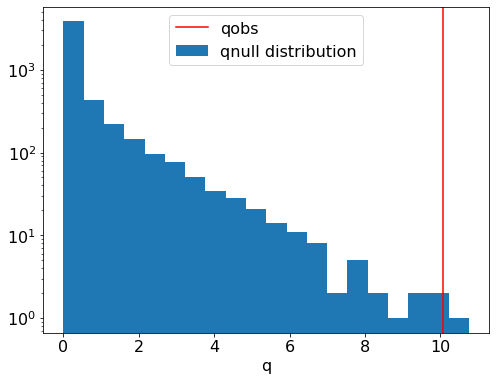

In [16]:
plt.hist(calculator.qnull(poinull, None, onesided=True, onesideddiscovery=True)[poinull], bins=20, label="qnull distribution", log=True)
plt.axvline(calculator.qobs(poinull, onesided=True, onesideddiscovery=True), color="red", label="qobs")
plt.legend(loc="best")
plt.xlabel("q")

In [17]:
calculator.to_yaml("toys/discovery_freq_zfit_toys.yml")